# AlexNet with Pytorch


## Connecting to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the Necessary

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torchvision
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler

## Loading Dataset

In [3]:
def get_train_valid_loader(data_dir,batch_size,augment,random_seed,valid_size=0.1,shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True,download=True, transform=train_transform, )

    valid_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=valid_transform, )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

In [4]:
transform = transforms.Compose(
    [transforms.Resize((227, 227)),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

#trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)

# Load the CIFAR10 dataset

trainloader, validloader = get_train_valid_loader(data_dir = './data', batch_size = 64, augment = False,random_seed = 1)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)



100%|██████████| 170498071/170498071 [00:01<00:00, 86125702.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

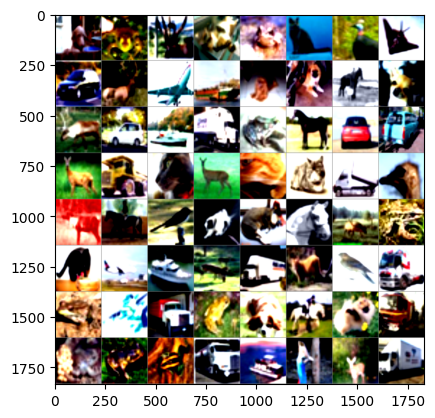

dog   frog  deer  cat   frog  cat   bird  plane car   deer  plane ship  dog   dog   horse dog   deer  car   ship  truck frog  horse car   car   deer  truck cat   deer  cat   cat   truck bird  deer  horse bird  dog   cat   horse deer  frog  cat   plane ship  deer  truck cat   bird  truck frog  plane truck frog  dog   horse dog   truck frog  frog  frog  truck ship  bird  deer  truck


In [6]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

## Building the Model

* The batch normalization layer normalizes the output of the convolutional layer across all batches to reduce overfitting.

* The output of the batch normalization layer is passed to the ReLU activation function.

* The ReLU activation function introduces non-linearity into the network and helps to improve the performance of the network.
The output of the ReLU activation function is passed to the max pooling layer, self.layer4. The max pooling layer reduces the spatial dimensions of the feature map by taking the maximum value from each pooling window.

In [7]:
class AlexNet(nn.Module):

  def __init__(self, num_classes=10):

    super(AlexNet, self).__init__()

    self.convolutional = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
        nn.BatchNorm2d(96),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(96, 256, kernel_size=5, padding=2),
         nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(256, 384, kernel_size=3, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 384, kernel_size=3, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2)

    )

    #self.avgpool = nn.AdaptiveAvgPool2d((6,6))

    self.linear = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),

        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),

        nn.Linear(4096, 10)

    )


  def forward(self, x):

    x = self.convolutional(x)

    x = torch.flatten(x, 1)
    x = self.linear(x)

    return x



In [8]:
model = AlexNet()

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [10]:
model.to(device)

AlexNet(
  (convolutional): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(384, 256, 

* The optimizer must be defined after we pass the model to GPU(cuda).

In [11]:
optimizer = optim.SGD(model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()

In [12]:
epochs = 22
train_loss = []
total_step = len(trainloader)

for epoch in range(epochs):
  total_train_loss = 0

  for idx, data in enumerate(trainloader, 0) :

    image, label = data
    image, label = data[0].to(device), data[1].to(device)

    if torch.cuda.is_available():
     model.cuda()


    optimizer.zero_grad()

    pred = model(image)
    loss = criterion(pred, label)

    total_train_loss += loss.item()

    loss.backward()
    optimizer.step()



  total_train_loss = total_train_loss / (idx + 1)
  train_loss.append(total_train_loss)

  print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, epochs, idx+1, total_step, loss.item()))


   # Validation
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))


print('Finished Training')

Epoch [1/22], Step [704/704], Loss: 1.6295
Accuracy of the network on the 5000 validation images: 44.86 %
Epoch [2/22], Step [704/704], Loss: 1.1329
Accuracy of the network on the 5000 validation images: 48.73 %
Epoch [3/22], Step [704/704], Loss: 0.5409
Accuracy of the network on the 5000 validation images: 60.03 %
Epoch [4/22], Step [704/704], Loss: 1.0580
Accuracy of the network on the 5000 validation images: 62.26 %
Epoch [5/22], Step [704/704], Loss: 0.7965
Accuracy of the network on the 5000 validation images: 64.1 %
Epoch [6/22], Step [704/704], Loss: 1.0550
Accuracy of the network on the 5000 validation images: 65.26 %
Epoch [7/22], Step [704/704], Loss: 0.4811
Accuracy of the network on the 5000 validation images: 73.54 %
Epoch [8/22], Step [704/704], Loss: 0.7151
Accuracy of the network on the 5000 validation images: 67.9 %
Epoch [9/22], Step [704/704], Loss: 0.4833
Accuracy of the network on the 5000 validation images: 72.11 %
Epoch [10/22], Step [704/704], Loss: 0.9669
Accu

In [13]:
PATH = '/content/drive/MyDrive/Input/CIFAR_10(1).pth'
torch.save(model.state_dict(), PATH)

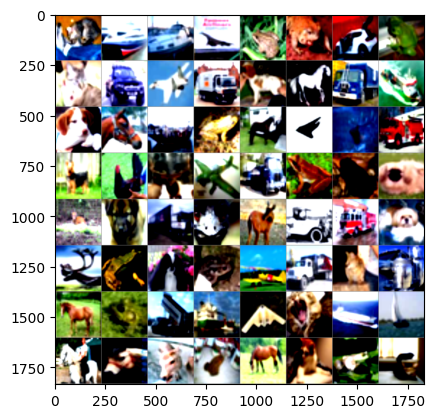

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat  


In [14]:
dataiter = iter(testloader)
images, label = next(dataiter)



# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[label[j]]:5s}' for j in range(64)))

In [15]:
images, label = images.cuda(), label.cuda()

In [16]:
outputs = model(images)

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(64)))

Predicted:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane plane truck deer  bird  deer  plane truck frog  frog  dog   deer  dog   truck car   deer  truck truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  truck dog   ship  ship  horse dog   cat   frog  horse dog   frog  cat  


In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data

        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 80 %


In [19]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data

        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 79.2 %
Accuracy for class: car   is 90.9 %
Accuracy for class: bird  is 73.0 %
Accuracy for class: cat   is 50.8 %
Accuracy for class: deer  is 85.2 %
Accuracy for class: dog   is 71.9 %
Accuracy for class: frog  is 88.2 %
Accuracy for class: horse is 80.9 %
Accuracy for class: ship  is 91.9 %
Accuracy for class: truck is 91.0 %


In [ ]:
#model = Alexnet()
#model.load_state_dict(torch.load(PATH))

In [ ]:
#plt.plot(train_loss)

In [ ]:
#testiter = iter(testloader)
#images. labels = testiter.next()

In [ ]:
#with torch.no_grad():
  #pred = model(images)